# EnKF Experiments - GCS

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import shapiro, kruskal
import seaborn as sns
import sys

In [2]:
sys.path.append('../../../../stationsim/')
from ensemble_kalman_filter import EnsembleKalmanFilter, AgentIncluder
from stationsim_gcs_model import Model

In [3]:
sys.path.append('../')
from experiment_utils import Modeller, Processor, Visualiser

In [4]:
%matplotlib inline
np.random.seed(42)

## Functions

In [5]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

In [6]:
def reduce_results(df, threshold=1):
    # Remove rows that are full of na's for all variables
    variable_names = ['forecast', 'obs', 'analysis', 'baseline']
    df = df.loc[~df[variable_names].isna().all(axis=1), :]
    print(f"Non-na times: {df['time'].max()} - {df['time'].min()}")

    # Identify times for which there are less than or equal to the threshold number of rows
    low_entry_series = df['time'].value_counts() <= threshold
    # Get set of unique times
    low_entry_times = set(low_entry_series[low_entry_series].index)

    times = set(df['time'].unique())
    keep_times = times - low_entry_times
    print(f'Low entry times: {max(low_entry_times)} - {min(low_entry_times)}')
    print(f'Times: {max(times)} - {min(times)}')
    print(f'Times to keep: {max(keep_times)} - {min(keep_times)}')
    results = df.loc[df['time'].isin(keep_times), :]

    return results

## Data paths

In [7]:
data_dir = '../results/data/exp2/'
model_dir = '../results/models/exp2/'
fig_dir = '../results/figures/exp2/'

## Experiment 1 - Setting Up EnKF

### Ensemble mode inclusion in error calculations

In [8]:
# Modeller.run_experiment_2(N=100, pop_size=20, inclusion=AgentIncluder.MODE_EN)

In [9]:
# Processor.process_experiment_2()

100%|██████████| 100/100 [04:54<00:00,  2.95s/it]


#### Read data

In [8]:
results = pd.read_csv(data_dir + 'p20/metrics.csv')
results.head()

,time,forecast,obs,analysis,baseline
0,0,NaN,NaN,NaN,NaN
1,20,24.845240,1.262811,1.094773,26.405860
2,40,7.666652,1.193813,4.180224,21.482055
3,60,9.440699,1.413836,2.301964,27.950053
4,80,16.875873,1.901203,2.124008,35.699334


In [9]:
variable_names = ['forecast', 'obs', 'analysis', 'baseline']

In [10]:
sum(results['analysis'].isna())

2591

In [11]:
len(results['analysis'])

20379

In [12]:
reduced_results = reduce_results(results, threshold=5)

Non-na times: 8760 - 20
Low entry times: 8760 - 4760
Times: 8760 - 20
Times to keep: 4740 - 20


In [13]:
results.shape

(20379, 5)

In [14]:
print(results['time'].min(), results['time'].max())

0 10000


In [15]:
reduced_results.shape

(17553, 5)

In [16]:
print(reduced_results['time'].min(), reduced_results['time'].max())

20 4740


In [17]:
mt = reduced_results['time'].max()
print(mt, len(reduced_results.loc[reduced_results['time']==mt, :]))

4740 6


#### Tidy up data

In [18]:
error_types = ['forecast', 'obs', 'analysis', 'baseline']

In [19]:
error_type_title = {'forecast': 'Forecast', 'obs': 'Observation',
                    'analysis': 'Analysis', 'baseline': 'Baseline'}

In [20]:
tidy_df = tidy_dataframe(results, 'time', error_types)

In [21]:
tidy_df_reduced = tidy_dataframe(reduced_results, 'time', error_types)

#### Plot results - mean

##### Original

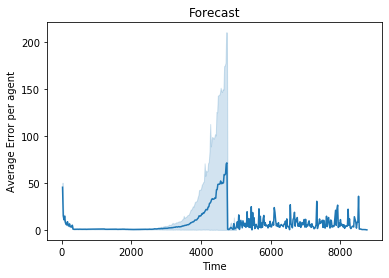

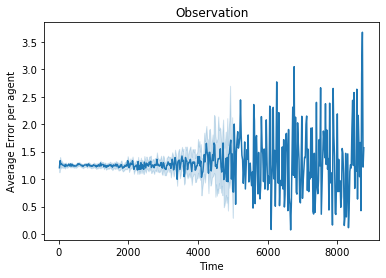

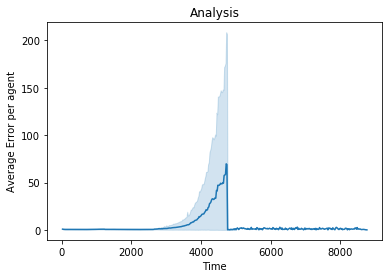

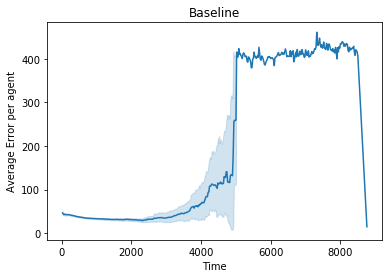

In [24]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.title(error_type_title[error_type])
    plt.xlabel('Time')
    plt.ylabel('Average Error per agent')
    plt.savefig(fig_dir + f'exp_2_MODE_EN_mean_{error_type}.pdf')
    plt.show()

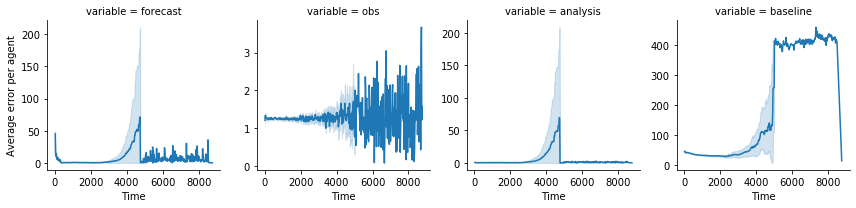

In [25]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value')
g.set_axis_labels('Time', 'Average error per agent')
g.savefig(fig_dir + 'exp_2_MODE_EN_mean_facet.pdf')

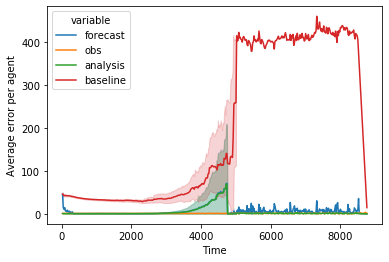

In [26]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'exp_2_MODE_EN_mean.pdf')
plt.show()

##### Exclude baseline

In [27]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']!='baseline'), :]

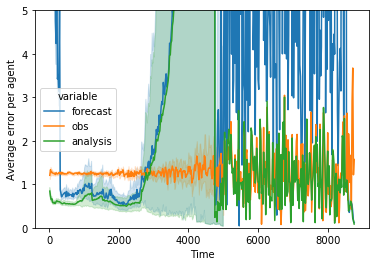

In [28]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_MODE_EN_mean_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [29]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

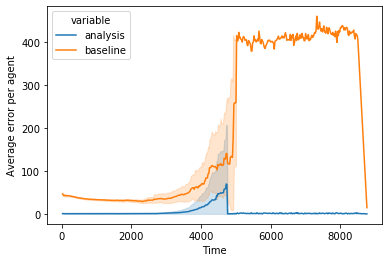

In [30]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'exp_2_MODE_EN_mean_reduced.pdf')
plt.show()

##### Reduced

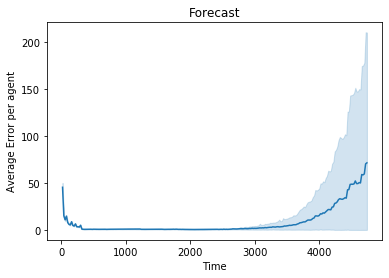

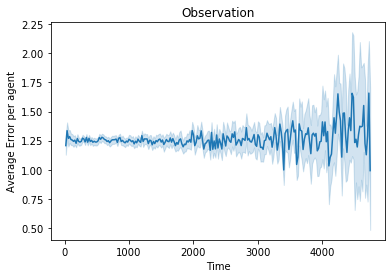

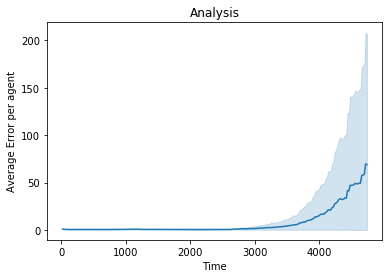

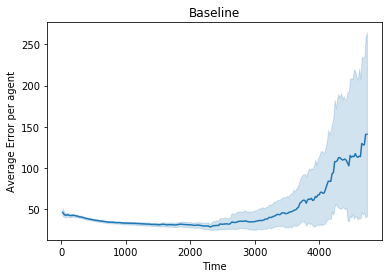

In [31]:
for error_type in error_types:
    df = tidy_df_reduced.loc[tidy_df_reduced['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.title(error_type_title[error_type])
    plt.xlabel('Time')
    plt.ylabel('Average Error per agent')
    plt.savefig(fig_dir + f'exp_2_reduced_MODE_EN_mean_{error_type}.pdf')
    plt.show()

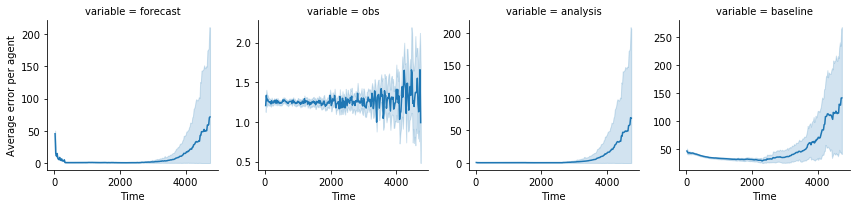

In [32]:
g = sns.FacetGrid(tidy_df_reduced, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value')
g.set_axis_labels('Time', 'Average error per agent')
g.savefig(fig_dir + 'exp_2_reduced_MODE_EN_mean_facet.pdf')

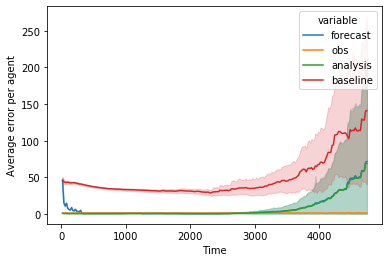

In [33]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df_reduced)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'exp_2_reduced_MODE_EN_mean.pdf')
plt.show()

##### Exclude baseline

In [34]:
reduced_tidy_df_reduced = tidy_df_reduced.loc[(tidy_df_reduced['variable']!='baseline'), :]

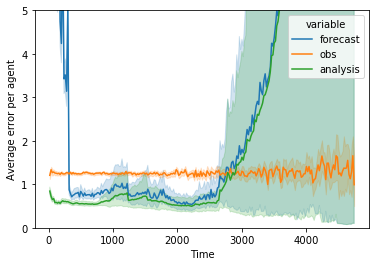

In [35]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df_reduced)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_reduced_MODE_EN_mean_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [36]:
reduced_tidy_df_reduced = tidy_df_reduced.loc[(tidy_df_reduced['variable']=='baseline') | (tidy_df_reduced['variable']=='analysis'), :]

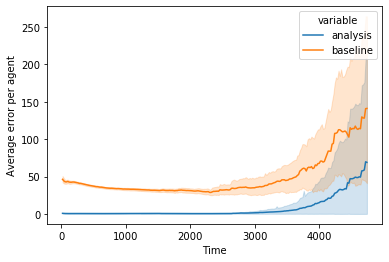

In [37]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df_reduced)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'exp_2_reduced_MODE_EN_mean_reduced.pdf')
plt.show()

#### Plot results - median

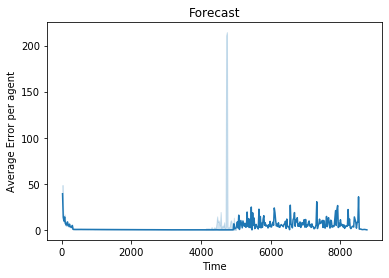

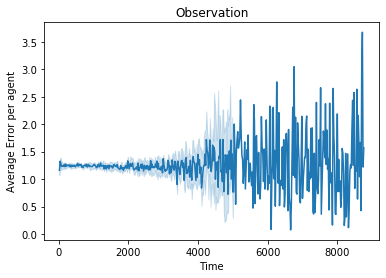

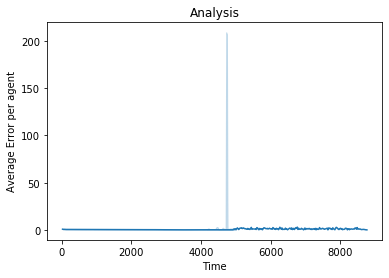

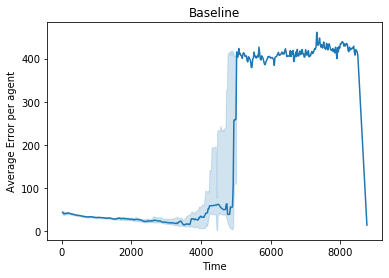

In [38]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df, estimator=np.median)
    plt.title(error_type_title[error_type])
    plt.xlabel('Time')
    plt.ylabel('Average Error per agent')
    plt.savefig(fig_dir + f'exp_2_MODE_EN_median_{error_type}.pdf')
    plt.show()

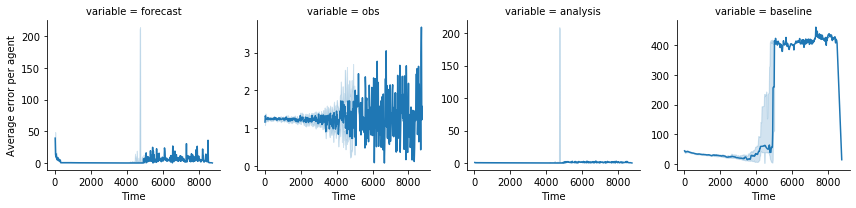

In [39]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value', estimator=np.median)
g.set_axis_labels('Time', 'Average error per agent')
g.savefig(fig_dir + 'exp_2_MODE_EN_median_facet.pdf')

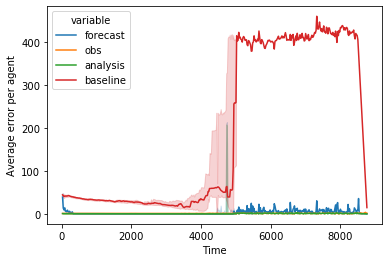

In [40]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df, estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'exp_2_MODE_EN_median.pdf')
plt.show()

##### Exclude baseline

In [41]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']!='baseline'), :]

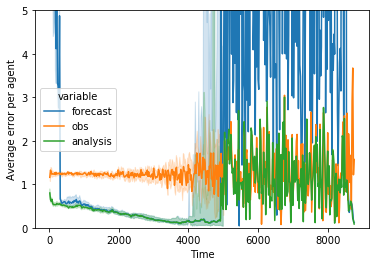

In [42]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_MODE_EN_median_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [43]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

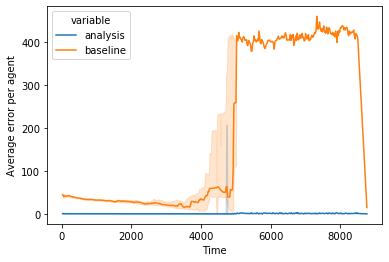

In [44]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'exp_2_MODE_EN_median_reduced.pdf')
plt.show()

##### Reduced

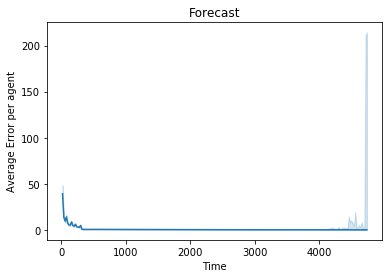

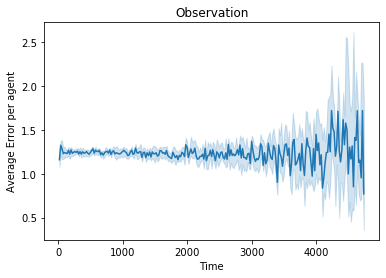

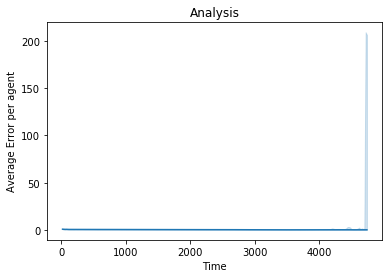

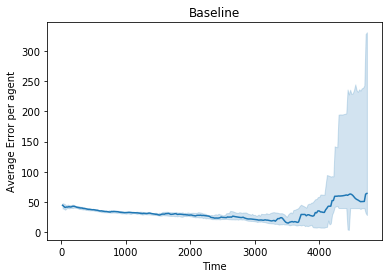

In [45]:
for error_type in error_types:
    df = tidy_df_reduced.loc[tidy_df_reduced['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df, estimator=np.median)
    plt.title(error_type_title[error_type])
    plt.xlabel('Time')
    plt.ylabel('Average Error per agent')
    plt.savefig(fig_dir + f'exp_2_reduced_MODE_EN_median_{error_type}.pdf')
    plt.show()

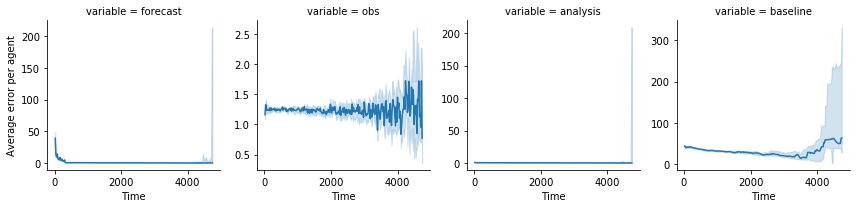

In [46]:
g = sns.FacetGrid(tidy_df_reduced, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value', estimator=np.median)
g.set_axis_labels('Time', 'Average error per agent')
g.savefig(fig_dir + 'exp_2_reduced_MODE_EN_median_facet.pdf')

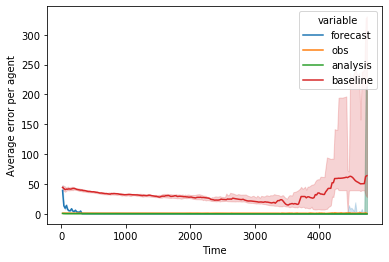

In [47]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df_reduced, estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'exp_2_reduced_MODE_EN_median.pdf')
plt.show()

##### Exclude baseline

In [48]:
reduced_tidy_df_reduced = tidy_df_reduced.loc[(tidy_df_reduced['variable']!='baseline'), :]

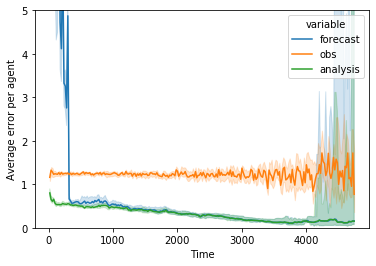

In [49]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df_reduced, estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_reduced_MODE_EN_median_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [50]:
reduced_tidy_df_reduced = tidy_df_reduced.loc[(tidy_df_reduced['variable']=='baseline') | (tidy_df_reduced['variable']=='analysis'), :]

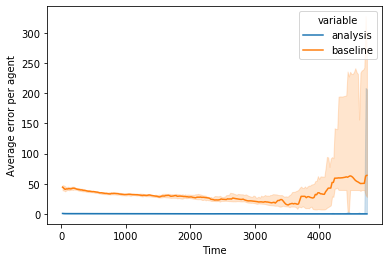

In [51]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df_reduced, estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'exp_2_reduced_MODE_EN_median_.pdf')
plt.show()

##### Outliers: Mean vs median and threshold vs no threshold

In [22]:
reduced_analysis_df = tidy_df_reduced.loc[(tidy_df_reduced['variable']=='analysis'), :]
analysis_df = tidy_df.loc[(tidy_df['variable']=='analysis'), :]

In [23]:
reduced_analysis_df.shape

(17553, 3)

In [24]:
analysis_df.shape

(20379, 3)

In [25]:
options = [(analysis_df, np.mean, 'Mean', 'No Threshold'),
           (analysis_df, np.median, 'Median', 'No Threshold'),
           (reduced_analysis_df, np.mean, 'Mean', 'Threshold'),
           (reduced_analysis_df, np.median, 'Median', 'Threshold')]

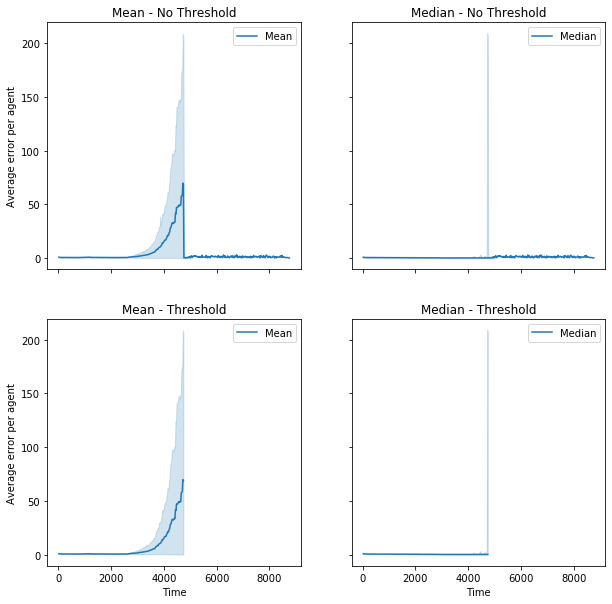

In [26]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    sns.lineplot(x='time', y='value', data=options[i][0], estimator=options[i][1], label=options[i][2], ci=95, ax=ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Average error per agent')
    ax.title.set_text(f'{options[i][2]} - {options[i][3]}')
plt.savefig(fig_dir + 'outlier_comparison.pdf')
plt.show()

### Analysing model endtimes

Read in data

In [27]:
end_times = pd.read_csv(data_dir + 'p20/end_times.csv')
end_times.head()

,model_number,end_time
0,0,4009
1,0,2937
2,0,4155
3,0,5104
4,0,3751


Plot histograms

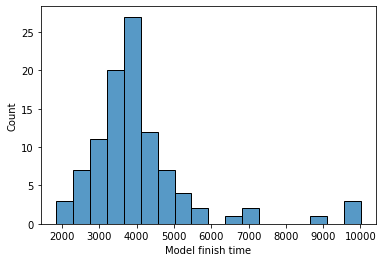

In [28]:
plt.figure()
sns.histplot(data=end_times, x='end_time')
plt.xlabel('Model finish time')
plt.savefig(fig_dir + 'end_time_hist.pdf')
plt.show()

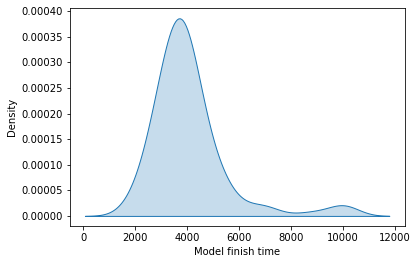

In [29]:
plt.figure()
sns.kdeplot(data=end_times, x='end_time', fill=True)
plt.xlabel('Model finish time')
plt.savefig(fig_dir + 'end_time_kde.pdf')
plt.show()

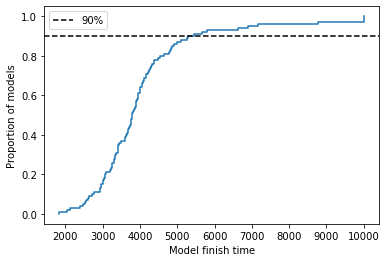

In [30]:
plt.figure()
sns.ecdfplot(data=end_times, x='end_time')
plt.axhline(0.9, linestyle='--', color='black', label='90%')
plt.xlabel('Model finish time')
plt.ylabel('Proportion of models')
plt.legend()
plt.savefig(fig_dir + 'end_time_cdf.pdf')
plt.show()

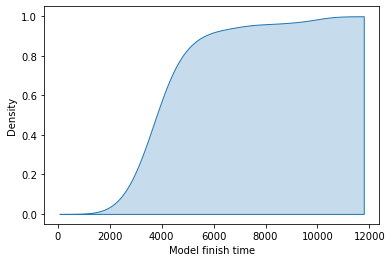

In [31]:
plt.figure()
sns.kdeplot(data=end_times, x='end_time', fill=True, cumulative=True)
plt.xlabel('Model finish time')
plt.savefig(fig_dir + 'end_time_kde_cdf.pdf')
plt.show()

#### Distribution of error and use of median vs mean

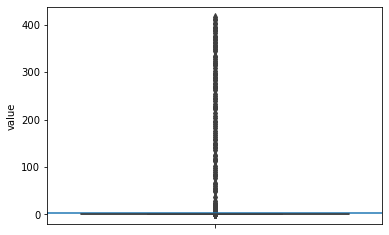

In [40]:
plt.figure()
sns.boxplot(data=reduced_analysis_df, y='value')
plt.axhline(reduced_analysis_df['value'].mean(), label='Mean')
plt.ylabel('Average error per agent')
plt.show()

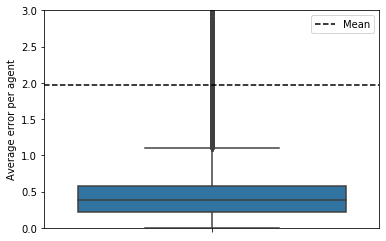

In [45]:
plt.figure()
sns.boxplot(data=reduced_analysis_df, y='value')
plt.axhline(reduced_analysis_df['value'].mean(), label='Mean', 
            linestyle='--', color='black')
plt.ylabel('Average error per agent')
plt.ylim((0, 3))
plt.legend()
plt.savefig(fig_dir + 'mean_boxplot.pdf')
plt.show()

#### Final truncated results

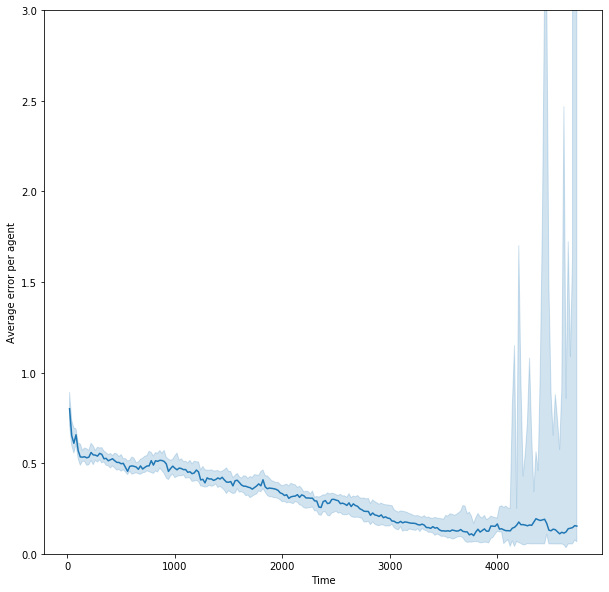

In [37]:
plt.figure(figsize=(10, 10))
sns.lineplot(x='time', y='value', data=reduced_analysis_df, estimator=np.median)
plt.ylim((0, 3))
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'truncated_median.pdf')
plt.show()

#### Truncated + Median

Baseline vs analysis

In [73]:
reduced_analysis_df = tidy_df_reduced.loc[((tidy_df_reduced['variable']=='analysis'))|(tidy_df_reduced['variable']=='baseline'), :]

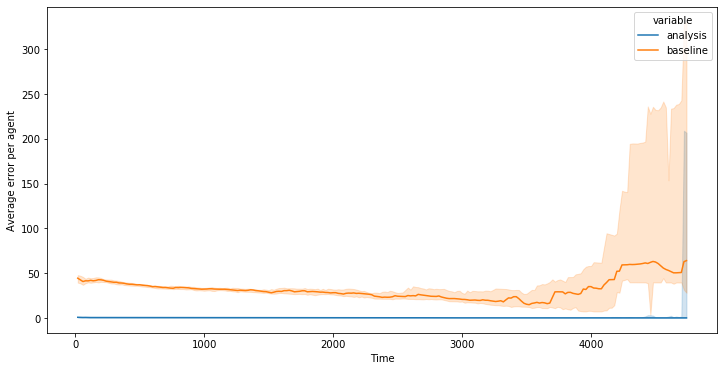

In [74]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='value', data=reduced_analysis_df, hue='variable', estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'truncated_median_analysis_baseline_line.pdf')
plt.show()

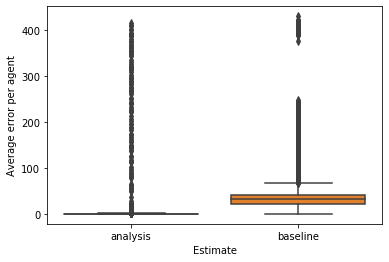

In [75]:
plt.figure()
sns.boxplot(x='variable', y='value', data=reduced_analysis_df)
plt.xlabel('Estimate')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'truncated_median_analysis_baseline_box.pdf')
plt.show()

/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


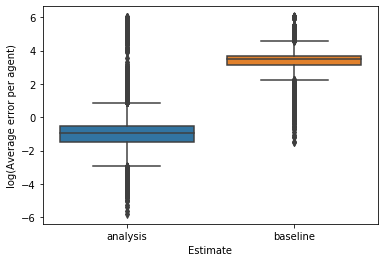

In [76]:
reduced_analysis_df.loc[:, 'log(val)'] = np.log(reduced_analysis_df.loc[:, 'value'])
plt.figure()
sns.boxplot(x='variable', y='log(val)', data=reduced_analysis_df)
plt.xlabel('Estimate')
plt.ylabel('log(Average error per agent)')
plt.savefig(fig_dir + 'truncated_median_analysis_baseline_log_box.pdf')
plt.show()

Forecast vs analysis

In [77]:
reduced_analysis_df = tidy_df_reduced.loc[((tidy_df_reduced['variable']=='analysis'))|(tidy_df_reduced['variable']=='forecast'), :]

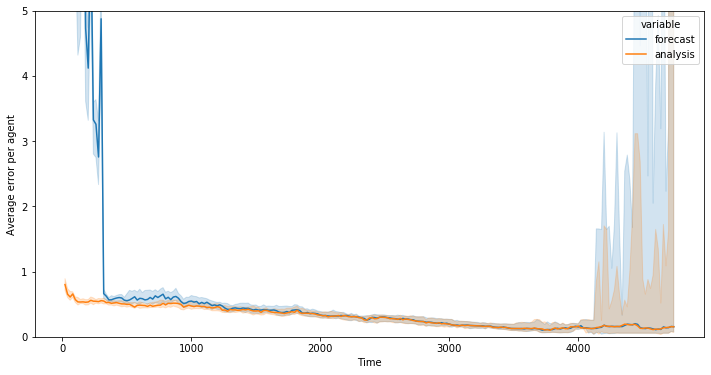

In [78]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='value', data=reduced_analysis_df, hue='variable', estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.ylim((0, 5))
plt.savefig(fig_dir + 'truncated_median_analysis_forecast_line.pdf')
plt.show()

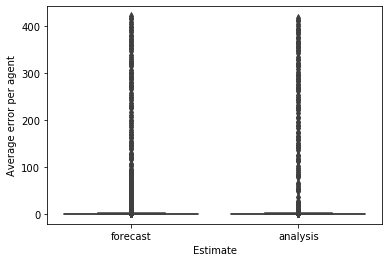

In [79]:
plt.figure()
sns.boxplot(x='variable', y='value', data=reduced_analysis_df)
plt.xlabel('Estimate')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'truncated_median_analysis_forecast_box.pdf')
plt.show()

/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


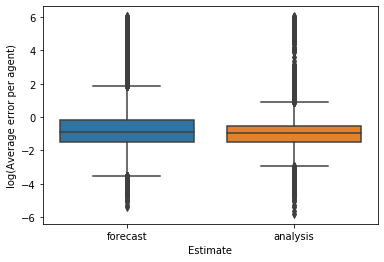

In [80]:
reduced_analysis_df.loc[:, 'log(val)'] = np.log(reduced_analysis_df.loc[:, 'value'])
plt.figure()
sns.boxplot(x='variable', y='log(val)', data=reduced_analysis_df)
plt.xlabel('Estimate')
plt.ylabel('log(Average error per agent)')
plt.savefig(fig_dir + 'truncated_median_analysis_forecast_log_box.pdf')
plt.show()

Observation vs analysis

In [81]:
reduced_analysis_df = tidy_df_reduced.loc[((tidy_df_reduced['variable']=='analysis'))|(tidy_df_reduced['variable']=='obs'), :]

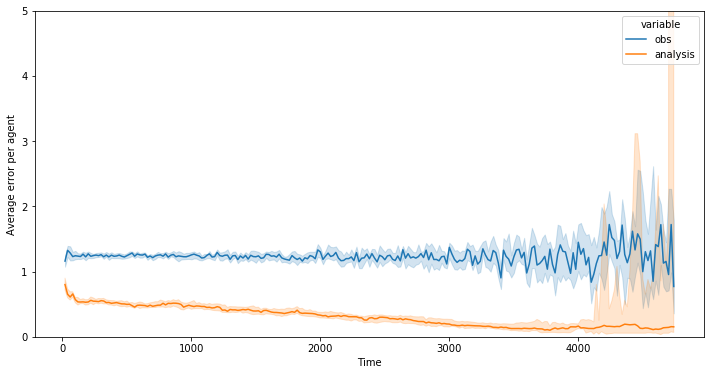

In [82]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='value', data=reduced_analysis_df, hue='variable', estimator=np.median)
plt.xlabel('Time')
plt.ylabel('Average error per agent')
plt.ylim((0, 5))
plt.savefig(fig_dir + 'truncated_median_analysis_obs_line.pdf')
plt.show()

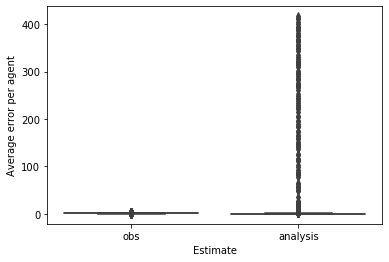

In [83]:
plt.figure()
sns.boxplot(x='variable', y='value', data=reduced_analysis_df)
plt.xlabel('Estimate')
plt.ylabel('Average error per agent')
plt.savefig(fig_dir + 'truncated_median_analysis_obs_box.pdf')
plt.show()

/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


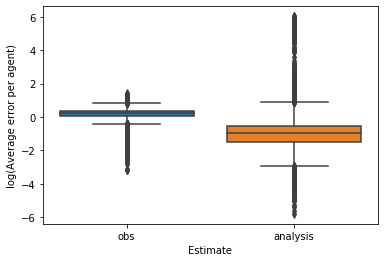

In [84]:
reduced_analysis_df.loc[:, 'log(val)'] = np.log(reduced_analysis_df.loc[:, 'value'])
plt.figure()
sns.boxplot(x='variable', y='log(val)', data=reduced_analysis_df)
plt.xlabel('Estimate')
plt.ylabel('log(Average error per agent)')
plt.savefig(fig_dir + 'truncated_median_analysis_obs_log_box.pdf')
plt.show()

### Base model inclusion in error calculations

In [8]:
Modeller.run_experiment_2(N=20, pop_size=20, inclusion=AgentIncluder.BASE)

  0%|          | 0/20 [00:00<?, ?it/s]../../../../stationsim/ensemble_kalman_filter.py:174: RuntimeWarning: EnKF received unexpected attribute (vanilla_ensemble_size).
  warns.warn(w, RuntimeWarning)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


  5%|▌         | 1/20 [02:28<47:05, 148.72s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 10%|█         | 2/20 [06:13<58:04, 193.60s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 15%|█▌        | 3/20 [08:25<46:53, 165.51s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 20%|██        | 4/20 [10:27<39:29, 148.10s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 25%|██▌       | 5/20 [12:22<34:06, 136.42s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 30%|███       | 6/20 [14:12<29:44, 127.43s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 35%|███▌      | 7/20 [16:07<26:41, 123.16s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 40%|████      | 8/20 [17:56<23:45, 118.78s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 45%|████▌     | 9/20 [20:16<23:00, 125.47s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 50%|█████     | 10/20 [21:54<19:28, 116.81s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 55%|█████▌    | 11/20 [23:25<16:21, 109.07s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 60%|██████    | 12/20 [25:33<15:17, 114.63s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 65%|██████▌   | 13/20 [28:14<15:02, 128.91s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 70%|███████   | 14/20 [30:02<12:14, 122.39s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 75%|███████▌  | 15/20 [32:39<11:04, 132.89s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 80%|████████  | 16/20 [34:42<08:39, 129.92s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 85%|████████▌ | 17/20 [37:15<06:50, 136.99s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 90%|█████████ | 18/20 [39:44<04:40, 140.43s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


 95%|█████████▌| 19/20 [41:41<02:13, 133.57s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE
ensemble_errors:	False


100%|██████████| 20/20 [44:30<00:00, 133.52s/it]


In [9]:
Processor.process_experiment_2()

100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


#### Read data

In [8]:
results = pd.read_csv(data_dir + 'p20/metrics.csv')
results.head()

,time,forecast,obs,analysis,baseline
0,0,NaN,NaN,NaN,NaN
1,20,50.774041,1.474649,0.620853,55.198350
2,40,11.656310,1.434847,0.734369,44.533723
3,60,2.332389,0.708345,0.420393,37.663293
4,80,21.481008,0.906532,0.453495,45.882946


In [9]:
reduced_results = reduce_results(results, threshold=2)

5340 4700
5340 0
4680 0


In [10]:
results.shape

(3818, 5)

In [11]:
reduced_results.shape

(3773, 5)

#### Tidy up data

In [12]:
error_types = ['forecast', 'obs', 'analysis', 'baseline']

In [13]:
tidy_df = tidy_dataframe(results, 'time', error_types)

In [14]:
tidy_df_reduced = tidy_dataframe(reduced_results, 'time', error_types)

#### Plot results - mean

##### Original

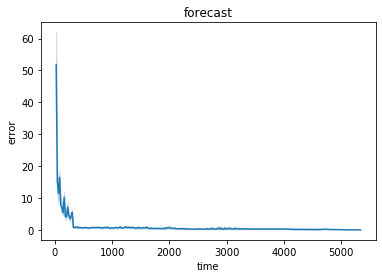

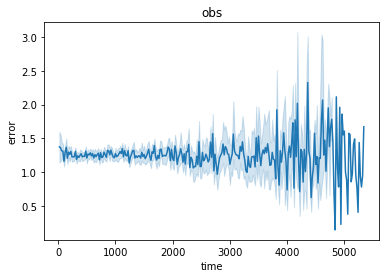

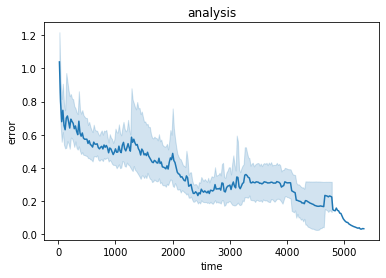

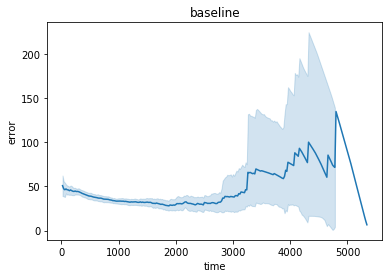

In [15]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_2_BASE_mean_{error_type}.pdf')
    plt.show()

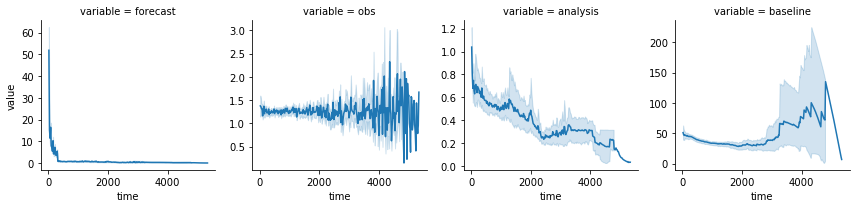

In [16]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value')
g.savefig(fig_dir + 'exp_2_BASE_mean_facet.pdf')

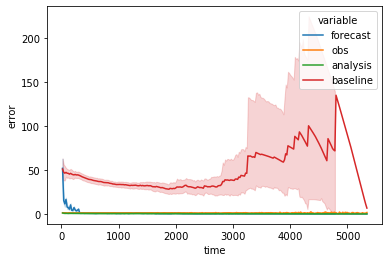

In [17]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_BASE_mean.pdf')
plt.show()

##### Exclude baseline

In [18]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']!='baseline'), :]

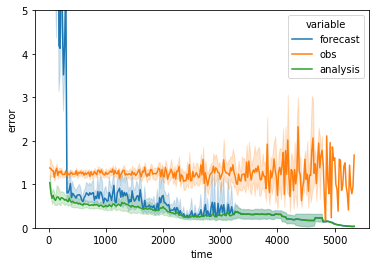

In [19]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_BASE_mean_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [20]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

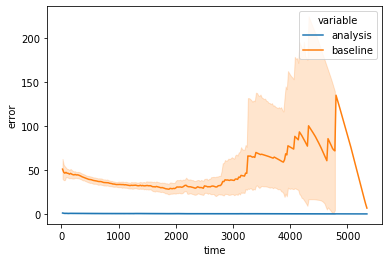

In [21]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_BASE_mean_reduced.pdf')
plt.show()

##### Reduced

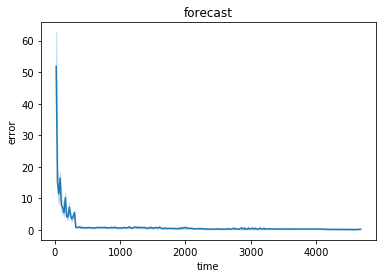

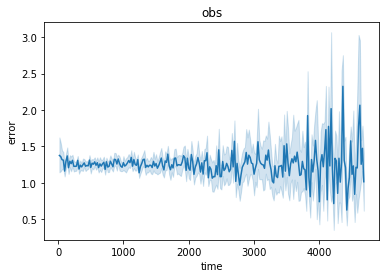

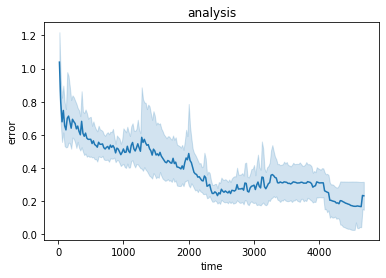

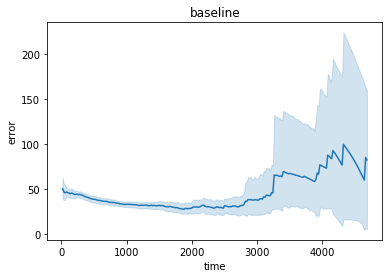

In [22]:
for error_type in error_types:
    df = tidy_df_reduced.loc[tidy_df_reduced['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_2_reduced_BASE_mean_{error_type}.pdf')
    plt.show()

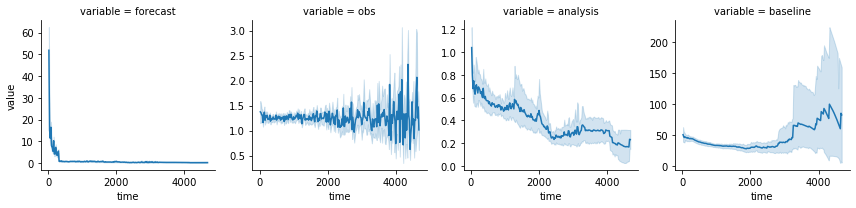

In [23]:
g = sns.FacetGrid(tidy_df_reduced, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value')
g.savefig(fig_dir + 'exp_2_reduced_BASE_mean_facet.pdf')

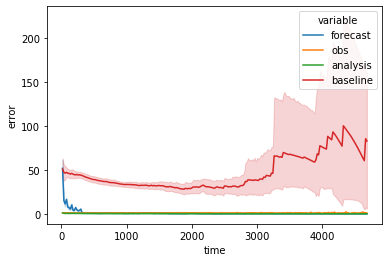

In [24]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df_reduced)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_reduced_BASE_mean.pdf')
plt.show()

##### Exclude baseline

In [25]:
reduced_tidy_df_reduced = tidy_df_reduced.loc[(tidy_df_reduced['variable']!='baseline'), :]

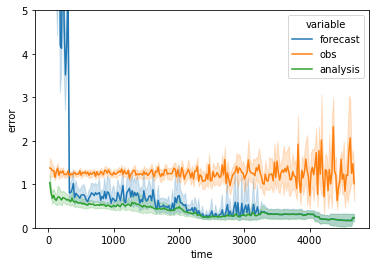

In [26]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df_reduced)
plt.ylabel('error')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_reduced_BASE_mean_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [27]:
reduced_tidy_df_reduced = tidy_df_reduced.loc[(tidy_df_reduced['variable']=='baseline') | (tidy_df_reduced['variable']=='analysis'), :]

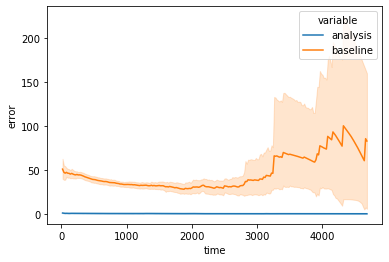

In [28]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df_reduced)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_reduced_BASE_mean_reduced.pdf')
plt.show()

#### Plot results - median

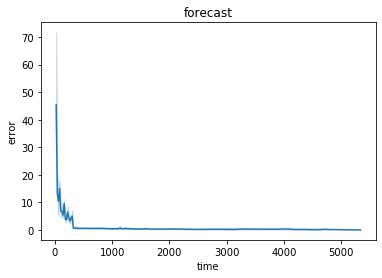

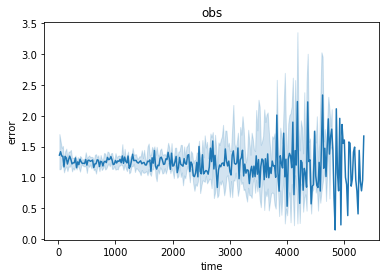

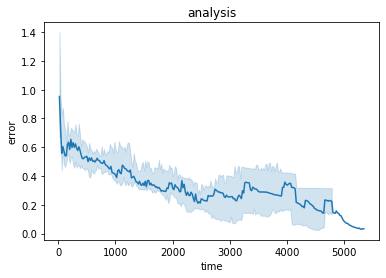

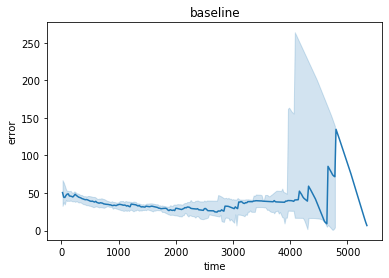

In [29]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df, estimator=np.median)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_2_BASE_median_{error_type}.pdf')
    plt.show()

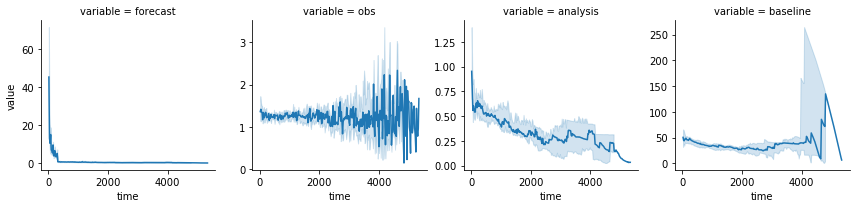

In [30]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value', estimator=np.median)
g.savefig(fig_dir + 'exp_2_BASE_median_facet.pdf')

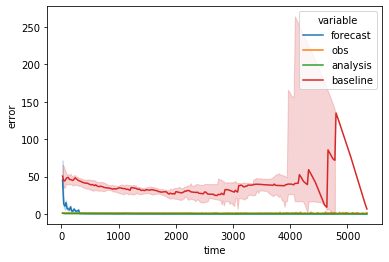

In [31]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_BASE_median.pdf')
plt.show()

##### Exclude baseline

In [32]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']!='baseline'), :]

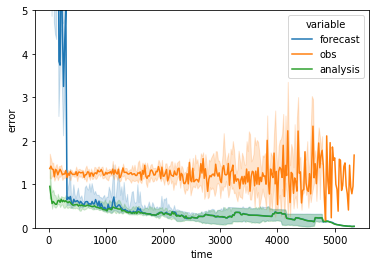

In [33]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.ylabel('error')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_BASE_median_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [34]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

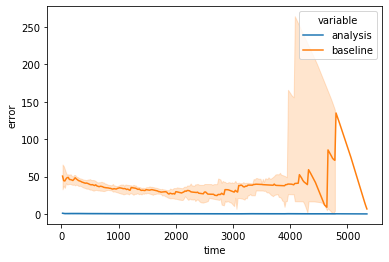

In [35]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_BASE_median_reduced.pdf')
plt.show()

##### Reduced

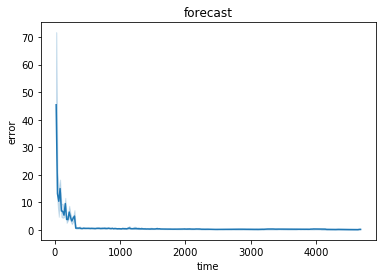

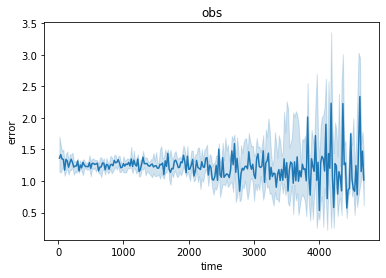

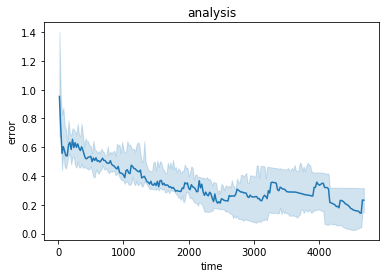

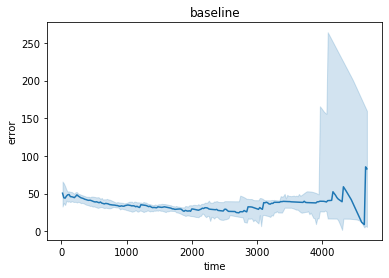

In [36]:
for error_type in error_types:
    df = tidy_df_reduced.loc[tidy_df_reduced['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df, estimator=np.median)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_2_reduced_BASE_median_{error_type}.pdf')
    plt.show()

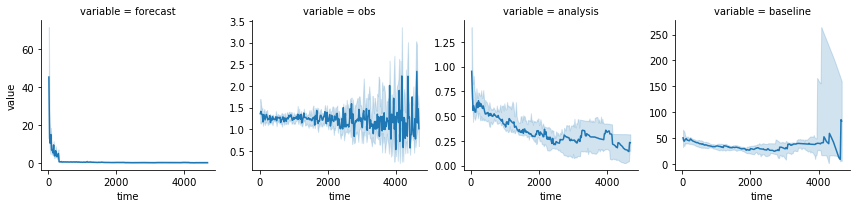

In [37]:
g = sns.FacetGrid(tidy_df_reduced, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value', estimator=np.median)
g.savefig(fig_dir + 'exp_2_reduced_BASE_median_facet.pdf')

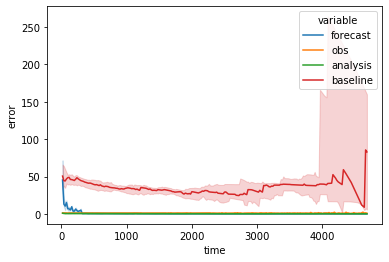

In [38]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df_reduced, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_reduced_BASE_median.pdf')
plt.show()

##### Exclude baseline

In [39]:
reduced_tidy_df_reduced = tidy_df_reduced.loc[(tidy_df_reduced['variable']!='baseline'), :]

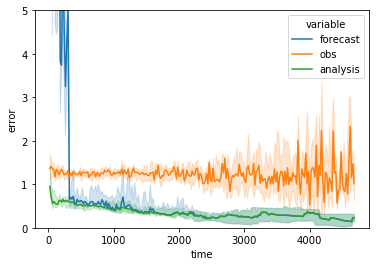

In [40]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df_reduced, estimator=np.median)
plt.ylabel('error')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_reduced_BASE_median_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [41]:
reduced_tidy_df_reduced = tidy_df_reduced.loc[(tidy_df_reduced['variable']=='baseline') | (tidy_df_reduced['variable']=='analysis'), :]

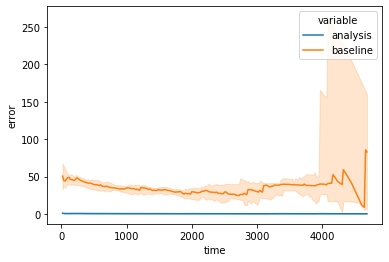

In [42]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df_reduced, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_reduced_BASE_median_reduced.pdf')
plt.show()